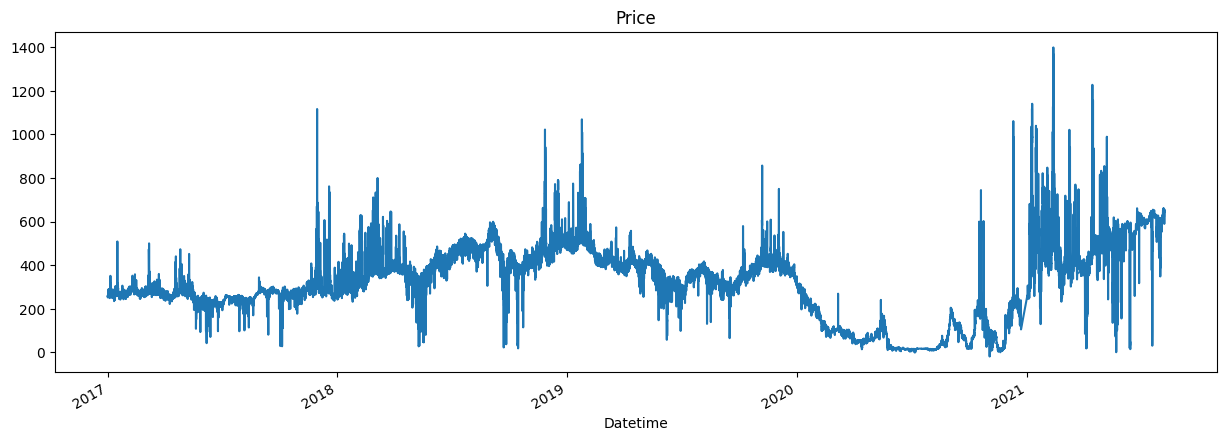

In [1]:

"""
This code is based on the code given by bernt for exercise 7

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler        #this nomralizes data 

horizon = 72  #sliding window size

loads = pd.read_excel(r'data/2017-2021.xlsx')
df = loads.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df['Kr.sand'].plot(
        figsize=(15, 5),
        title='Price')
plt.show()


loads_training = df.values

In [16]:
df

,Oslo,DK1,SYS,SE1,SE2,SE3,SE4,FI,DK2,Bergen,Molde,Tr.heim,Tromsø,EE,LV,LT,Kr.sand
Datetime,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,257.74,190.22,233.24,218.08,218.08,218.08,218.08,218.08,190.22,257.74,218.08,218.08,218.08,218.08,218.08,218.08,257.74
2017-01-01 01:00:00,255.66,189.68,232.42,218.08,218.08,218.08,218.08,218.08,189.68,255.66,218.08,218.08,218.08,218.08,218.08,218.08,255.66
2017-01-01 02:00:00,254.39,164.54,231.33,217.99,217.99,217.99,217.99,217.99,164.54,254.39,217.99,217.99,217.99,217.99,217.99,217.99,254.39
2017-01-01 03:00:00,254.11,145.48,229.16,210.46,210.46,210.46,210.46,210.46,145.48,254.11,210.46,210.46,210.46,210.46,210.46,210.46,254.11
2017-01-01 04:00:00,254.30,149.11,232.61,218.72,218.72,218.72,218.72,218.72,149.11,254.30,218.72,218.72,218.72,218.72,218.72,218.72,254.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-06 18:00:00,655.66,795.30,657.54,655.66,655.66,655.66,795.30,814.85,795.30,655.66,655.66,655.66,600.06,814.85,814.85,814.85,655.66
2021-08-06 19:00:00,654.72,867.11,657.33,640.61,640.61,640.61,867.11,853.00,867.11,654.72,640.61,640.61,599.64,888.43,888.43,888.43,654.72
2021-08-06 20:00:00,652.42,880.80,639.25,583.54,583.54,583.54,880.80,583.54,880.80,652.42,583.54,583.54,583.54,880.80,880.80,880.80,652.42


In [2]:
def create_features(df):
    df = df.copy()

    df['month'] = df.index.month

    return df

df = create_features(df)

In [3]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size = 0.3, random_state = 123)

train = create_features(train)
test = create_features(test)
#For Oslo
FEATURES = ['Kr.sand','SYS','SE1','SE3','DK2','Bergen', 'month']
TARGET = 'Oslo'
#For KristianSand
#FEATURES = ['Oslo','Bergen','Tromsø','DK1', 'month']
#TARGET = 'Kr.sand'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
X_train_scaled = scaler.fit_transform(X_train)
y_train_reshaped = y_train.values.reshape(1, -1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

features_set = []
labels = []
for i in range(horizon,len(X_train.values)):                                     
    features_set.append(X_train_scaled[i-horizon:i+1,0])
    labels.append(y_train_scaled[0,i])
        
features_set,labels = np.array(features_set),np.array(labels)  

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1],1))   #this is an efficient way of transofmring data to numpy arrays for further work



In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras import callbacks

features_set,labels = np.array(X_train),np.array(y_train)  

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1],1))   #this is an efficient way of transofmring data to numpy arrays for further work


optimizer = optimizers.Adam(clipvalue=0.5)


#this just specifies the architecture of the LSTM network (check spring lecture) - it is a linear string of LSTM nodes
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))             #there is a 20% drop out rate here to avoid too much bias

#**** Adding mode LSTM nodes to the sequential string  - we are building a train !!
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

#we close the string of neurons with a fully connected unit (dense) which simply consist of one node, we need only one price estimate
model.add(Dense(units = 1))

#here we are asking kersas to build our LSTM model according to the specifications listed in the form programming steps
callback = callbacks.EarlyStopping(monitor='loss', patience=5)

model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['acc'])  # ADAM is a version of the gradient asccent algo that drives backprop

#Ready to train - again some important meta paramters . The number of epochs and the batch size
model.fit(features_set, labels, epochs = 100, batch_size = 10,callbacks=[callback])

Epoch 1/100
2805/2805 [==============================] - 37s 11ms/step - loss: 77970.2109 - acc: 0.0000e+00
Epoch 2/100
2805/2805 [==============================] - 34s 12ms/step - loss: 21747.9609 - acc: 0.0000e+00
Epoch 3/100
2805/2805 [==============================] - 34s 12ms/step - loss: 5857.9805 - acc: 0.0000e+00
Epoch 4/100
2805/2805 [==============================] - 34s 12ms/step - loss: 3741.8455 - acc: 0.0000e+00
Epoch 5/100
2805/2805 [==============================] - 34s 12ms/step - loss: 3338.3408 - acc: 0.0000e+00
Epoch 6/100
2805/2805 [==============================] - 34s 12ms/step - loss: 3110.7175 - acc: 0.0000e+00
Epoch 7/100
2805/2805 [==============================] - 33s 12ms/step - loss: 2995.3516 - acc: 0.0000e+00
Epoch 8/100
2805/2805 [==============================] - 30s 11ms/step - loss: 2896.2075 - acc: 0.0000e+00
Epoch 9/100
2805/2805 [==============================] - 29s 10ms/step - loss: 2822.8203 - acc: 0.0000e+00
Epoch 10/100
2805/2805 [===========

In [8]:


test_features,Labels = np.array(X_test),np.array(y_test)  
test_features
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

#here the fun starts - now we set off to predict with the test set to see how close our predictions comes to the referene value in the test set
predictions = model.predict(test_features)


376/376 [==============================] - 3s 5ms/step


In [9]:
test['predictions'] = predictions
test

,Oslo,DK1,SYS,SE1,SE2,SE3,SE4,FI,DK2,Bergen,Molde,Tr.heim,Tromsø,EE,LV,LT,Kr.sand,month,predictions
Datetime,,,,,,,,,,,,,,,,,,,
2020-10-17 15:00:00,215.61,224.82,202.24,215.61,215.61,215.61,224.82,215.61,224.82,215.61,132.96,132.96,132.96,224.82,224.82,224.82,215.61,10,220.361923
2018-08-04 14:00:00,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,488.86,524.35,524.35,488.86,8,495.986176
2017-02-12 21:00:00,287.97,287.97,285.92,287.97,287.97,287.97,287.97,287.97,287.97,287.97,287.97,287.97,219.28,287.97,287.97,287.97,287.97,2,306.637360
2019-11-06 16:00:00,616.98,616.98,642.69,616.98,616.98,616.98,616.98,766.06,616.98,616.98,616.98,616.98,616.98,766.06,766.06,766.06,616.98,11,561.168518
2021-04-29 08:00:00,823.01,847.57,810.33,829.00,829.00,829.00,829.00,829.00,829.00,823.01,829.00,829.00,829.00,829.00,829.00,829.00,823.01,4,644.678711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-20 11:00:00,15.57,230.87,22.23,135.08,135.08,135.08,135.08,135.08,230.87,15.57,18.25,18.25,18.25,476.02,476.02,476.02,15.57,6,15.727075
2017-08-24 01:00:00,262.98,274.14,261.77,288.65,288.65,288.65,288.65,288.65,288.65,262.98,263.82,263.82,214.35,288.65,288.65,288.65,262.98,8,274.589600
2020-12-14 20:00:00,250.79,386.08,256.51,268.79,268.79,386.08,509.62,761.58,509.62,250.79,149.90,149.90,149.90,392.14,392.14,392.14,250.79,12,270.801788


<Figure size 1500x500 with 0 Axes>

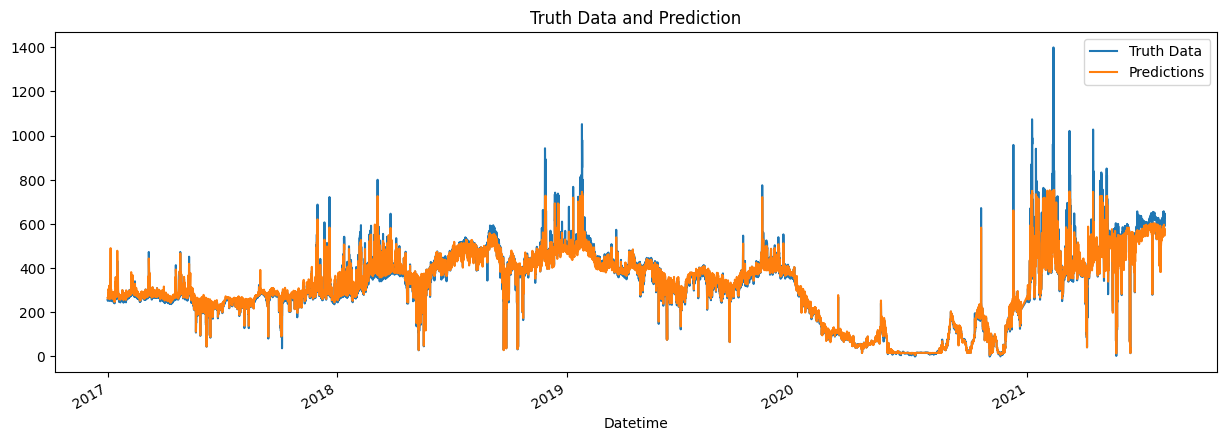

In [69]:
plt.figure(figsize=(15,5))



ax = test[['Kr.sand']].plot(figsize=(15, 5))
test['predictions'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Truth Data and Prediction')
plt.show()



<Figure size 1500x500 with 0 Axes>

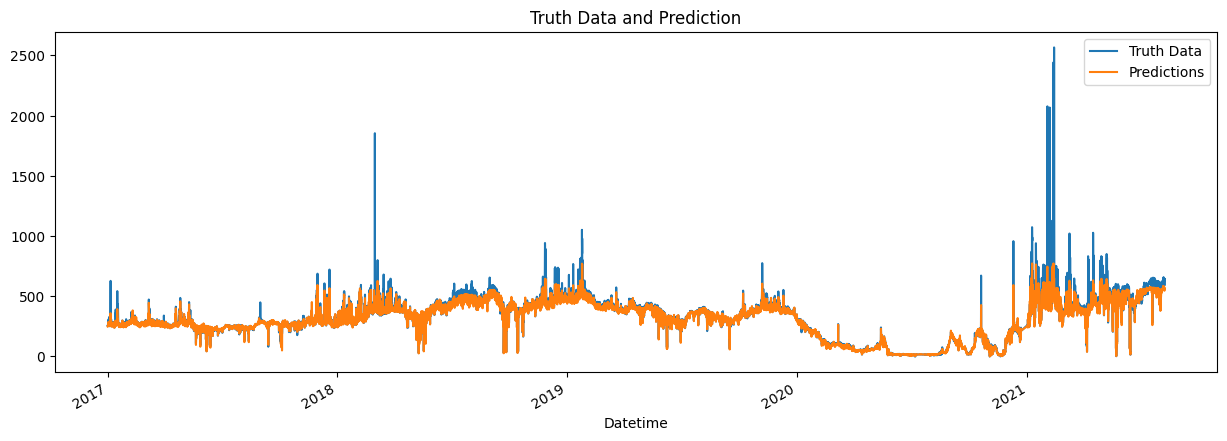

In [104]:
plt.figure(figsize=(15,5))



ax = test[['Oslo']].plot(figsize=(15, 5))
test['predictions'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Truth Data and Prediction')
plt.show()


In [87]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(Labels, predictions))
print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(Labels, predictions)
print('Test MSE: %.3f' % mse)
core = model.evaluate(X_train,y_train) 
print("Training score: ", score)


scores = model.evaluate(X_train, y_train, verbose=1)
print(scores*100)

scores = model.evaluate(X_test, y_test, verbose=1)
print(scores*100)

model.metrics_names[0]

Test RMSE: 24.003
Test MSE: 576.145
877/877 [==============================] - 4s 4ms/step - loss: 603.3870
Training score:  603.3870239257812
877/877 [==============================] - 3s 3ms/step - loss: 603.3870
60338.702392578125
376/376 [==============================] - 1s 3ms/step - loss: 576.1448
57614.4775390625


'loss'

In [118]:
test['error'] = np.abs(test[TARGET] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-02-11    549.842058
2021-02-01    380.811659
2021-02-05    333.166062
2021-02-12    307.405128
2018-03-01    231.306767
2021-01-08    149.499241
2021-03-08    135.329201
2019-01-24    119.753210
2018-11-26    116.316348
2019-01-31     94.321127
Name: error, dtype: float64

In [72]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_45 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_46 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_46 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_47 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_47 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_48 (LSTM)              (None, 64)              